In [1]:
using Revise, JLD2, LinearAlgebra, PyPlot, Tullio, Statistics, PottsGauge, DelimitedFiles, DCAUtils

In [2]:
include("../src/dca_score.jl")
include("../src/utils.jl")
;

In [3]:
let alphabet = [ 1, 21, 2, 3, 4, 5, 6, 7, 8, 21, 9, 10, 11, 12, 21, 13, 14, 15, 16, 17, 21, 18, 19, 21, 20]
               # A, B,  C, D, E, F, G, H, I, J,  K, L,  M,  N,  O,  P,  Q,  R,  S,  T,  U,  V,  W,  X,  Y
    global letter2num
    function letter2num(c::Union{Char,UInt8})
        i = UInt8(c) - 0x40
        1 <= i <= 25 && return alphabet[i]
        return 21
     end
end

let alphabet = ["A", "C", "D", "E", "F", "G", "H", "I",  "K", "L",  "M",  "N", "P",  "Q",  "R",
"S",  "T", "V",  "W",  "Y"]
    global num2letter
    function num2letter(i :: Integer)
        1 <= i <= 20 && return alphabet[i]
        return "-"
    end
end



num2letter (generic function with 1 method)

In [4]:
tt = ["A", "C", "F", "I", "L", "M", "V", "W", "Y", "P", "H", "K", "R", "D", "E", "N", "Q", "S", "T", "G"];
natural_ord = [1, 2, 14, 15, 3, 20, 11, 4, 12, 5, 6, 16, 10, 17, 13, 18, 19, 7, 8, 9];

In [5]:
function masked_attention(filestruct, atts; min_separation = 6, cutoff=8.0)
    dist = compute_residue_pair_dist(filestruct)
    
    for (key,value) in dist
        if key[2]-key[1]<=min_separation || value > cutoff || value == 0 
            delete!(dist,key)
        end
    end
    
    dist = reduce(hcat,getindex.(collect(keys(dist)),i) for i in 1:2)
    L = size(atts,1)
    H = size(atts,3)
    masked_att = zeros(L,L,H)
    for h in 1:H
        for i in 1:size(dist,1)
            masked_att[dist[i,1],dist[i,2], h] = atts[dist[i,1],dist[i,2], h]
            masked_att[dist[i,2],dist[i,1], h] = atts[dist[i,2],dist[i,1], h]
        end
    end
    return masked_att
end
        

masked_attention (generic function with 1 method)

In [6]:
function int_matr(A; tt = tt, titolo = false, nametitle = "Interaction Matrix")
    matshow(A)
    xticks(0:19,tt)
    yticks(0:19,tt)
    tick_params(axis="both", which="both", bottom=false, top=false)
    if titolo == true
        title(nametitle)
    end        
    colorbar()
end

function zerosumgaug(m; mj = false)
    E_col = mean(m, dims = 2)
    E_row = mean(m, dims = 1)
    E_tot = mean(m)
    if mj == true
        res = -m .+ E_col .+ E_row .- E_tot;
    else
        res = m .- E_col .- E_row .+ E_tot
    end
    return res
end

function eigen_an(m, n_eig; tit = " ciao")  #the matrix should already be in the proper form
    l, vv = eigen(m)
    scatter(1:length(l), l);
    ord = sortperm(abs.(l), rev=true)
    ll = l[sortperm(abs.(l), rev=true)]
    scatter(ord[1:n_eig], ll[1:n_eig]);
    print("Explained Var : ")
    println(round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(l))), digits = 2))
    int_matr(m, titolo = true, nametitle = "Total " * tit)
    for i in 1:n_eig
        tit1 = "Proj l = $(round(ll[i], digits=2)) "
        int_matr(vv[:,ord[i]]' .* vv[:,ord[i]], titolo = true, nametitle = tit1 * tit); 
    end
end

function compute_mat_mf(m)
    Vm = m.V[order_Martin,:]
    Nf = length(m.Ks)
    H = size(m.V,2)
    JJ = []
    for f in 1:Nf
        @tullio J[i,j,a,b] := m.Ks[f][i,j,h]*Vm[a,h]*Vm[b,h]*(j!=i)
        push!(JJ, J)
    end
    J0 = [mean(mean(JJ[f], dims = 3), dims=4) for f in 1:Nf]  
    JJ_zs = [JJ[f] .- mean(JJ[f], dims = 3) .- mean(JJ[f], dims = 4) .+ J0[f] for f in 1:Nf]
    println([sum(dropdims(dropdims(mean(mean(JJ_zs[f], dims = 1), dims=2),
                    dims=1),dims=1), dims=1) for f in 1:Nf])
    e_all = mean([dropdims(dropdims(mean(mean(JJ_zs[f], dims = 1), dims=2),
                    dims=1),dims=1) for f in 1:Nf])
    return e_all
end

function compute_mat_sf(m)
    Vm = m.V[order_Martin,:]
    H = size(m.V,2)
    @tullio J[i,j,a,b] := m.K[i,j,h]*Vm[a,h]*Vm[b,h]*(j!=i)
    J0 = mean(mean(J, dims = 3), dims=4)  
    JJ_zs = J .- mean(J, dims = 3) .- mean(J, dims = 4) .+ J0 
    e_all = dropdims(dropdims(mean(mean(JJ_zs, dims = 1), dims=2),
                    dims=1),dims=1)
    println(sum(e_all, dims=1))
    println(sum(e_all, dims=2))
    return e_all
end

function showVmat_mf(m, n_eig, structfiles; tit = " ")
    Nf = length(m.Ks)
    @tullio VV[a, b, h] := m.V[a,h]*m.V[b,h]
    llh = get_filt_mat_mf2(m1.Ks, m1.V, structfiles, ppv_cutoff = 0.8)
    #llh = mean([@tullio lam[h] := m1.Ks[f][i,j,h]*m1.Ks[f][i,j,h]*(j!=i) for f in 1:Nf]);
    ord = sortperm(abs.(llh), rev=true)
    ll = llh[sortperm(abs.(llh), rev=true)]
    close("all"); scatter(1:length(llh), llh)
    scatter(ord[1:n_eig], ll[1:n_eig])
    ex_var = round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(llh))), digits = 2)
    print("Explained variance : ")
    println(ex_var)
    for i in 1:n_eig
        int_matr(VV[order_Martin,order_Martin, ord[i]],
        titolo = true, nametitle = "Vmat l = $(round(ll[i], digits=2)) " * tit); 
    end
end

function showVmat_mf_uns(m, n_eig; tit = " ", min_dist = 6, perc = 0.125)
    Nf = length(m.Ks)
    @tullio VV[a, b, h] := m.V[a,h]*m.V[b,h]
    N = maximum([size(m.Ks[f], 1) for f in 1:Nf])
    H = size(m.Ks[1], 3)
    KK = zeros(N,N,H)
    counts = zeros(N, N, H)
    for f in 1:Nf
        for h in 1:size(m.V,2)
            #mm = 
            #mm_zsg = mm .- mean(mm, dims = 1) .- mean(mm, dims = 2) .- mean(mean(mm, dims = 1), dims = 2)
            L = size(m.Ks[f][:,:,h], 1)
            masked = set_elements_to_zero(m.Ks[f][:,:,h], min_dist)
            #masked = set_elements_to_zero(m.Ks[f][:,:,h], min_dist)
            good_cont = get_highest_vals(correct_APC(sqrt.(masked .^2)), round(Int,perc * L))
            
            for n in 1:length(good_cont)
                KK[good_cont[n][1], good_cont[n][2], h] += good_cont[n][3]
                counts[good_cont[n][1], good_cont[n][2], h] += 1
            end
        end
    end
     
    KK[KK.!=0] ./= counts[KK.!=0]
    @tullio llh[h] := KK[i,j,h]
    ord = sortperm(abs.(llh), rev=true)
    ll = llh[sortperm(abs.(llh), rev=true)]
    close("all"); scatter(1:length(llh), llh)
    scatter(ord[1:n_eig], ll[1:n_eig])
    ex_var = round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(llh))), digits = 2)
    print("Explained variance : ")
    println(ex_var)
    for i in 1:n_eig
        int_matr(VV[order_Martin,order_Martin, ord[i]],
        titolo = true, nametitle = "Vmat l = $(round(ll[i], digits=2)) " * tit); 
    end
end

function showVmat_sf(m, n_eig; tit = " ")
    @tullio VV[a, b, h] := m.V[a,h]*m.V[b,h]
    VV0 = mean(mean(VV,dims = 1), dims=2)
    VVV = VV .- mean(VV, dims=1) .- mean(VV, dims=2) .- VV0
    println(sum(VVV[:,:,1], dims=1))
    println(sum(VVV[:,:,1], dims=2))
    @tullio llh[h] := m1.K[i,j,h]*(j!=i);
    ord = sortperm(abs.(llh), rev=true)
    ll = llh[sortperm(abs.(llh), rev=true)]
    close("all"); scatter(1:length(llh), llh)
    scatter(ord[1:n_eig], ll[1:n_eig])
    ex_var = round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(llh))), digits = 2)
    print("Explained variance : ")
    println(ex_var)
    for i in 1:n_eig
        int_matr(VVV[order_Martin,order_Martin, ord[i]],
        titolo = true, nametitle = "Vmat l = $(round(ll[i], digits=2)) " * tit); 
    end
    return VV
end


showVmat_sf (generic function with 1 method)

In [7]:
function get_highest_vals(matrix, n)
    flattened_matrix = vec(matrix)  # Flatten the matrix into a 1D array
    sorted_indices = sortperm(flattened_matrix, rev=true)  # Sort indices in descending order
    
    highest_n_indices = sorted_indices[1:n]
    highest_n_values = flattened_matrix[highest_n_indices]
    
    indices_values_tuples = [(div(ind - 1, size(matrix, 1)) + 1, rem(ind - 1, size(matrix, 1)) + 1, val) for (ind, val) in zip(highest_n_indices, highest_n_values)]
    return indices_values_tuples
end

function set_elements_to_zero(matrix, dist)
    m, n = size(matrix)
    new_matrix = copy(matrix)  # Create a copy of the original matrix
    
    for i in 1:m
        for j in 1:n
            if abs(i - j) < dist
                new_matrix[i, j] = 0
            end
        end
    end
    
    return new_matrix
end

set_elements_to_zero (generic function with 1 method)

In [8]:
@load "../../extra/InteractionMatrix.jld2"

7-element Vector{Symbol}:
 :E
 :E1
 :E2
 :order_MJ
 :order_Martin
 :E1_natural
 :E1_martin

## Miyazawa Jernigan

Explained Var : [0.34, 0.53, 0.62, 0.7]


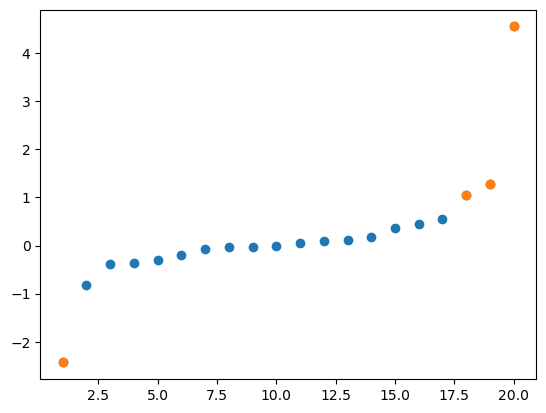

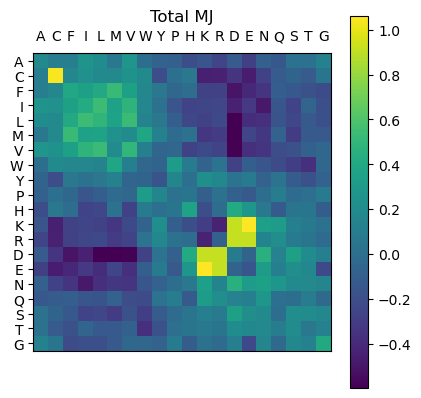

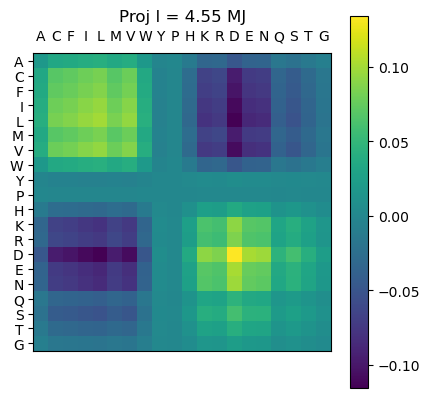

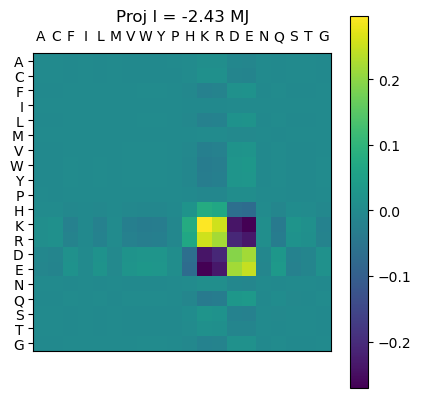

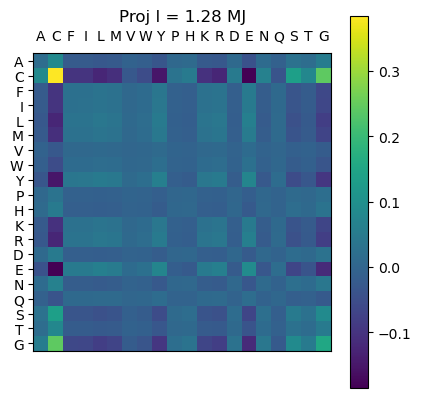

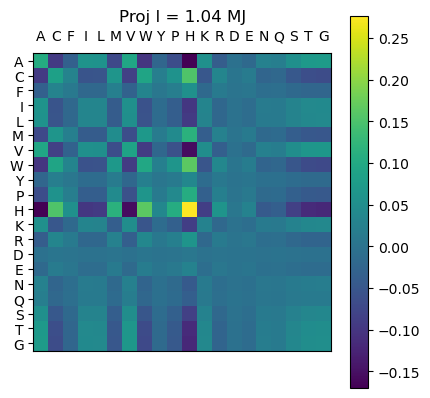

In [9]:
EE = zerosumgaug(E1_martin, mj = true)
n_eig = 4
eigen_an(EE, n_eig, tit = "MJ")

In [22]:
## vv[:,1] is eigenvecor of first value vv[:,10] is ocnstant and not in zero sum gauge, but l[10] is 0
l, vv = eigen(EE)
v = zeros(21, 21);
v[1:20,1:20] .= vv[natural_ord,1:20]
v[1:20,21] .= 0.1*rand(20)
v[21,1:20] .= 0.1*rand(20)
v[21,21] = 0.9
ll = ones(21)
ll[1:20] .= l[1:20]
ll[21] = 0.6
v = Float32.(v);

In [25]:
v = zeros(21, 21);
v[1:20,1:20] .= vv[natural_ord,1:20]
v[1:20,21] .= 0.
v[21,1:20] .= 0.
v[21,21] = 1.
ll = ones(21)
ll[1:20] .= l[1:20]
ll[21] = 0.6
v = Float32.(v);

In [24]:
@save "../../mj_eigen.jld2" EE l vv

In [26]:
println(sum(v[1:20,:], dims = 1)[1:20])

Float32[3.3527613f-8, -5.9604645f-8, -1.1269003f-7, -2.9802322f-8, -1.1920929f-7, 0.0, -2.9802322f-8, -4.4703484f-8, 0.0, -4.4721355, -3.1664968f-8, 5.9604645f-8, 1.3411045f-7, 9.685755f-8, 1.0058284f-7, 1.8626451f-8, -4.4703484f-8, 2.2351742f-8, 1.3411045f-7, -8.381903f-8]


In [28]:
@save "../../mj_eigen_with_gap.jld2" l v 

In [14]:
extrema(sum(EE, dims = 1))

(1.3322676295501878e-15, 1.8207657603852567e-14)

In [28]:
res = []
for i in 1:20
    for j in i:20
        push!(res, v[:,i]'*v[:,j])
    end
end

In [29]:
sum((res.> 0.001) .& (res.< 0.9))

90

In [18]:
EE * vv[1,:] ./vv[1,:]

20-element Vector{Float64}:
  -6.457264202109357
   8.492686659079594
   2.329887553914443
   4.536292511784567
  -1.8665913516496377
   0.5264625943361007
  -1.819035290205718
  -0.20363394505685137
 -14.025030457151338
  -0.49132073526374676
  -1.2181466916955435
  -1.6415231357395874
  -1.4411956915007862
  -2.269867346189071
 -20.886243140473237
   0.9345414821690741
 -11.662607327271804
  -0.5601456313163765
  -1.5154834527256196
   0.709421698141419

In [11]:
n_eig = 21
new_miya = zeros(21,21)
most_imp = sortperm(abs.(ll), rev = true);

for x in most_imp[1:n_eig]
    new_miya .+= ll[x] .* v[vcat(order_Martin,21),x]' .* v[vcat(order_Martin,21),x]
end

matshow(new_miya)
colorbar()    

LoadError: UndefVarError: `ll` not defined

In [ ]:
@tullio V[a, b, h] := v[a,h] * v[b,h] ;

In [ ]:
@save "../../SparseHop.jl/data/eigvec_miyazawa_J.jld2" l V

In [12]:
@save "../../data_Genie/eigvec_mj.jld2" v

Explained variance : [0.09, 0.15, 0.2, 0.26]


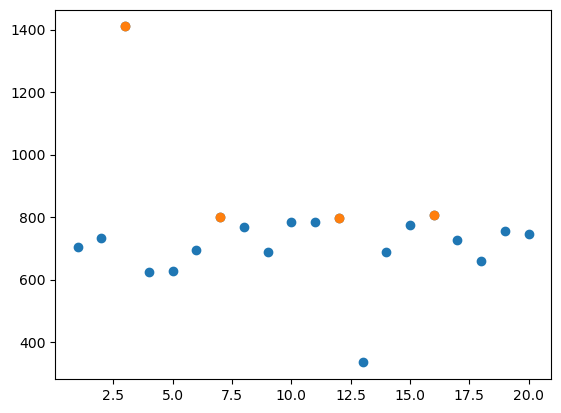

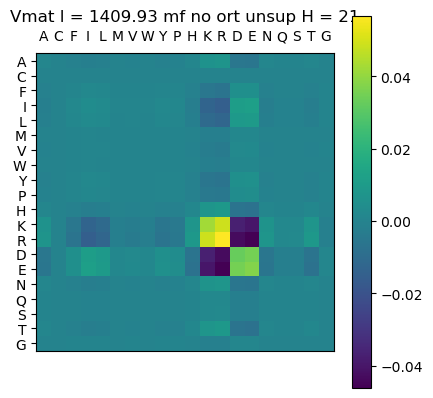

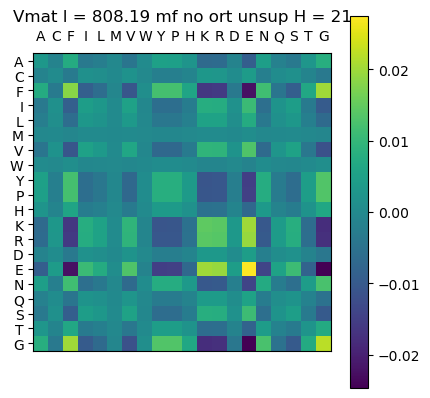

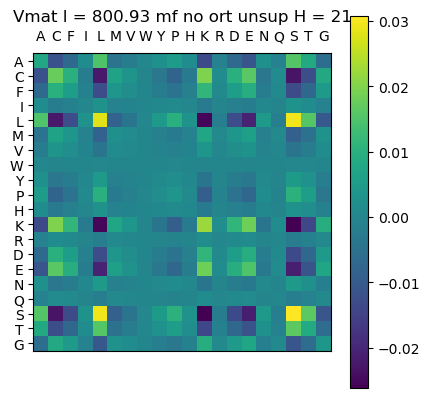

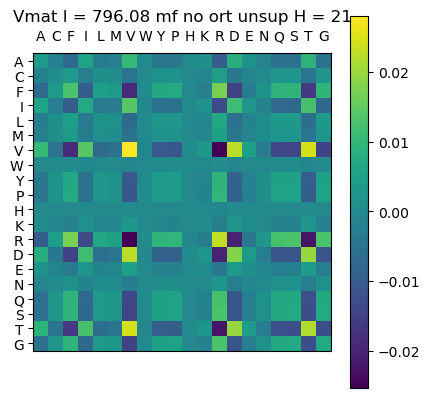

In [23]:
@load "../../multi_fam/ortfalse_H20η0.05λ0.001/12_fams_pars_H20.jld2"
m1 = m ; n_eig = 4;
showVmat_mf_uns(m1, n_eig, tit = "mf no ort unsup H = 21")

In [26]:
V = rand(21,21,20)
for i in 1:20
    V[:,:,i] .= m1.V[:,i]' .* m1.V[:,i]
end
V = Float32.(V)
;

In [27]:
@save "../../SparseHop.jl/data/V_12_fams_pars_H20" V

## Multi family with ort

In [ ]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
structfiles = ["../../DataAttentionDCA/data/PF00014/PF00014_struct.dat", 
    "../../DataAttentionDCA/data/PF00763/Atomic_distances_PF00763.dat",
    "../../DataAttentionDCA/data/PF00677/Atomic_distances_PF00677.dat",
    "../../DataAttentionDCA/data/PF00076/PF00076_struct.dat",
    "../../DataAttentionDCA/data/PF00035/Atomic_distances_PF00035.dat"]
aa = get_filt_mat_mf(m1.Ks, m1.V, structfiles, ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "mf with ort filtered")
;

In [ ]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
aa = compute_mat_mf(m1)
eigen_an(aa, n_eig, tit = "mf with ort")
;

Explained variance : [0.07, 0.13, 0.19, 0.25, 0.31, 0.36]


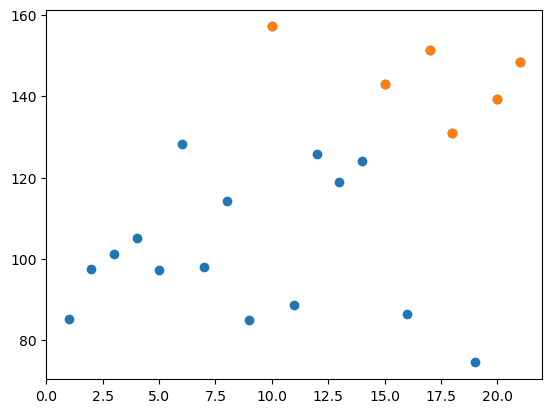

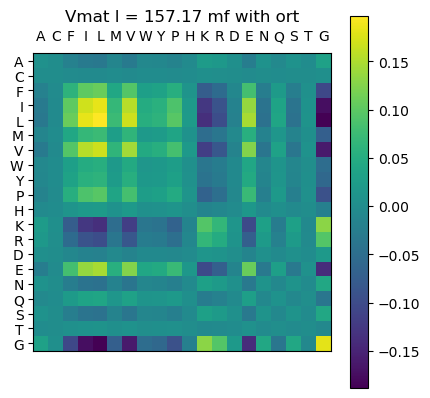

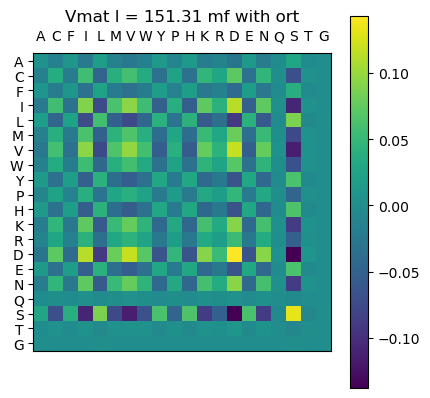

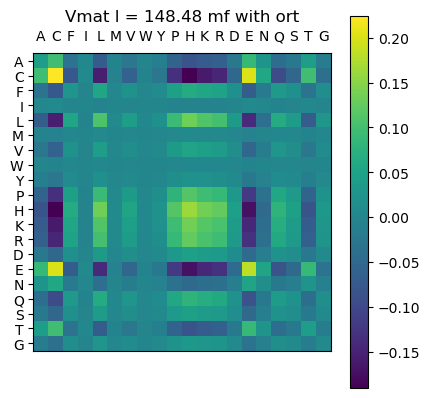

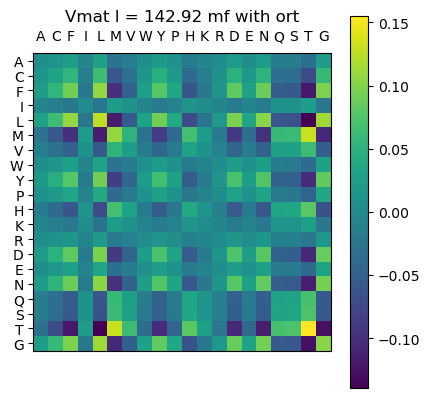

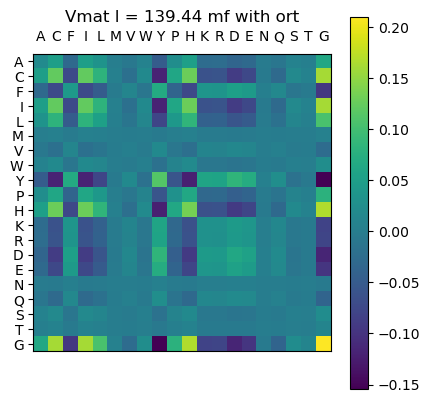

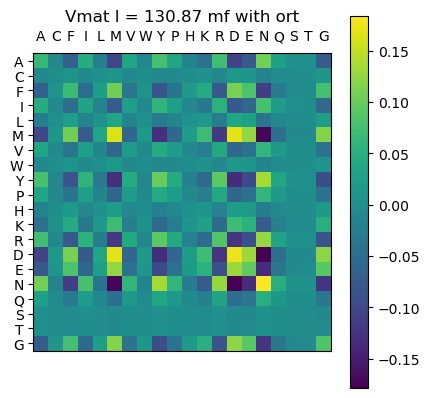

In [368]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
showVmat_mf_uns(m1, n_eig, tit = "mf with ort", perc = 0.5)
;

## Single family with ort

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf with ort filtered")
;

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ;n_eig = 4; 
#single family
aa = compute_mat_sf(m1)
eigen_an(aa, n_eig, tit = "sf with ort")
;

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ; n_eig = 4; 
showVmat_sf(m1, n_eig, tit = "sf with ort");

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf no ort filtered")
;

## Single family no ort

Float32[1.8626451f-9 -4.656613f-10 1.8626451f-9 2.3283064f-10 3.7252903f-9 0.0 -1.8626451f-9 4.656613f-10 9.313226f-10 2.7939677f-9 8.731149f-11 -1.1059456f-9 4.8894435f-9 0.0 -9.895302f-10 3.0267984f-9 9.313226f-10 2.3283064f-10 -1.1641532f-9 1.8626451f-9]
Float32[2.7939677f-9; 2.7939677f-9; 3.7252903f-9; -1.3969839f-9; 9.313226f-10; 6.4028427f-10; -2.3283064f-10; -6.9849193f-10; 1.9790605f-9; 9.313226f-10; -3.4924597f-10; -1.6880222f-9; 3.3760443f-9; 4.656613f-10; 1.5133992f-9; -6.9849193f-10; 0.0; -6.9849193f-10; -3.7252903f-9; 1.8626451f-9;;]
Explained Var : Float32[0.23, 0.4, 0.51, 0.61]


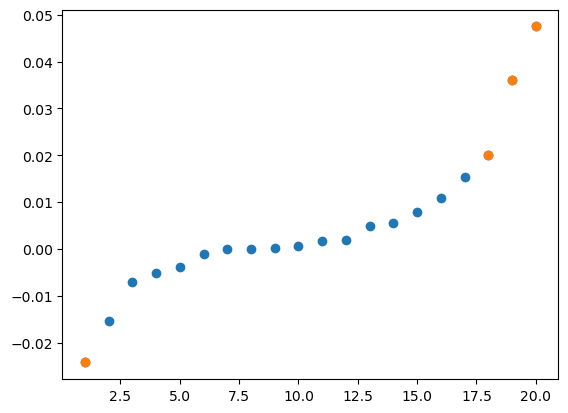

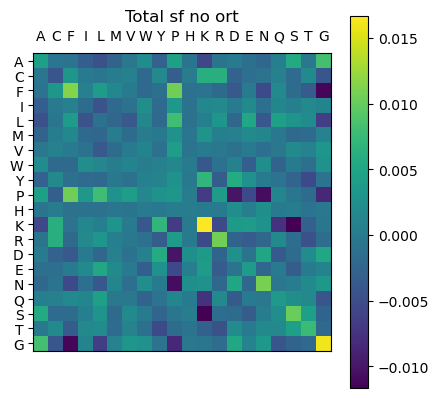

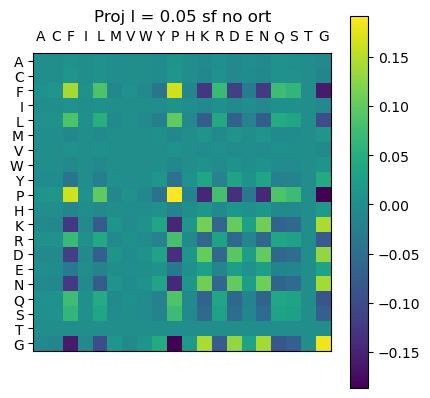

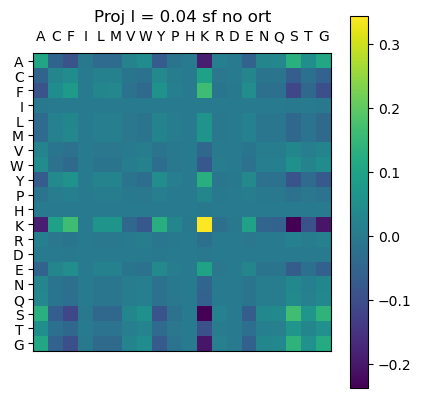

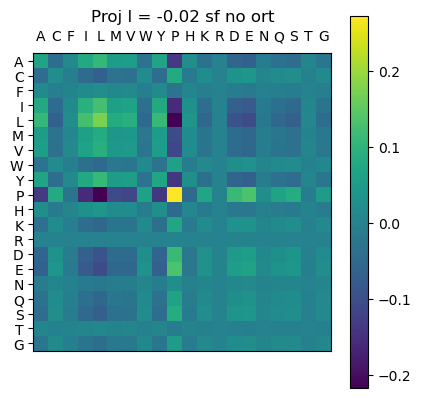

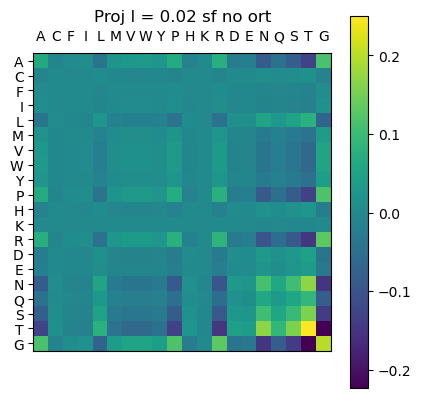

In [229]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4;
#single family
aa = compute_mat_sf(m1)
eigen_an(aa, n_eig, tit = "sf no ort")
;


Float32[-0.00035775732 -0.00035767257 -0.0003577564 -0.0003577564 -0.00035775919 -0.0003577657 -0.00035775919 -0.00035775942 -0.0003577508 -0.00035774894 -0.0003577564 -0.00035774335 -0.00035775453 -0.00035776012 -0.00035776943 -0.00035775825 -0.00035774522 -0.00035776198 -0.00035778433 -0.00035775884 -0.00035778806]
Float32[-0.0003577536; -0.00035767257; -0.0003577564; -0.0003577564; -0.00035775919; -0.0003577657; -0.00035775919; -0.00035775942; -0.00035775453; -0.00035775267; -0.0003577564; -0.00035774335; -0.0003577508; -0.00035775825; -0.00035776943; -0.00035775825; -0.00035774522; -0.0003577564; -0.00035778433; -0.00035775884; -0.00035778806;;]
Explained variance : Float32[0.16, 0.25, 0.34, 0.43]


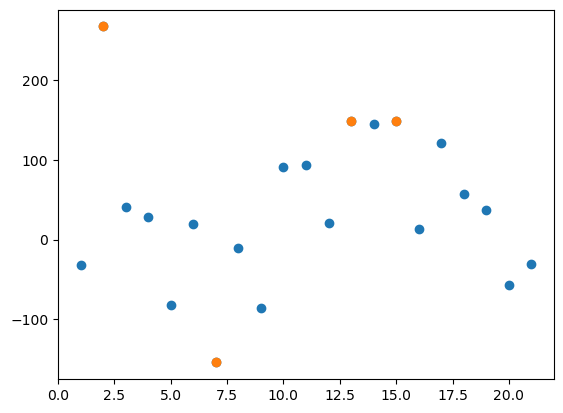

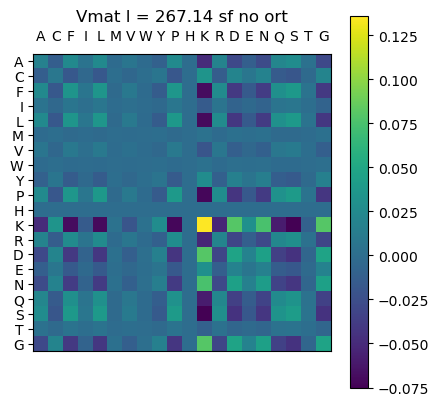

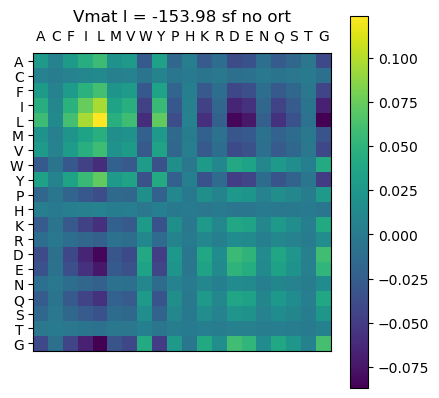

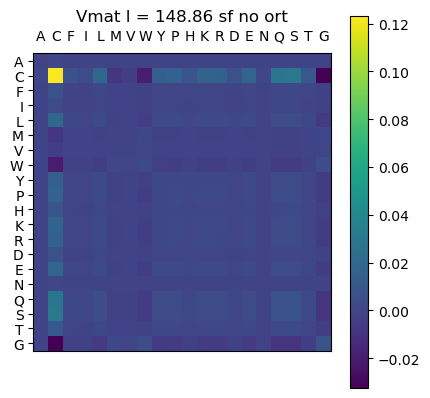

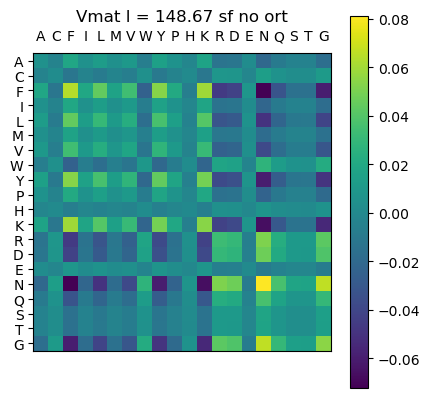

In [230]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4; 
VV1 = showVmat_sf(m1, n_eig, tit = "sf no ort");

Explained Var : [0.23, 0.43, 0.54, 0.62]


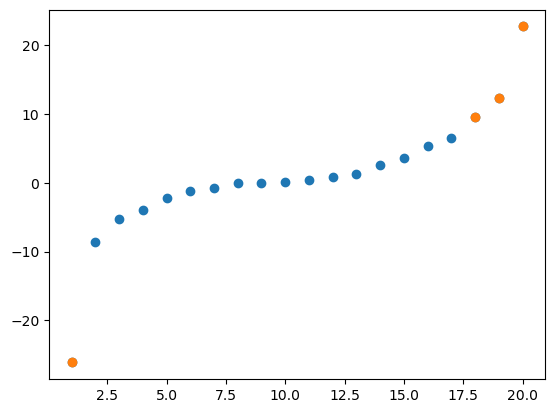

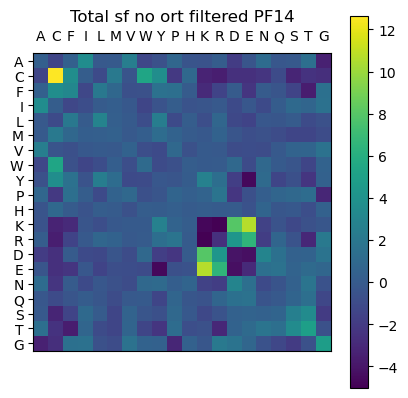

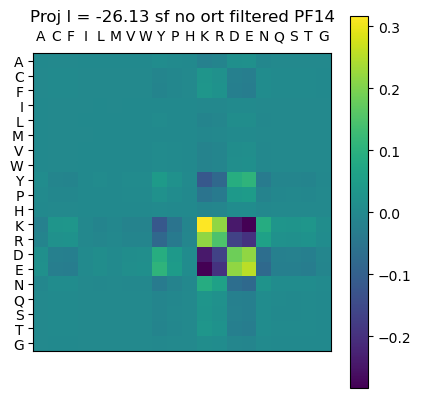

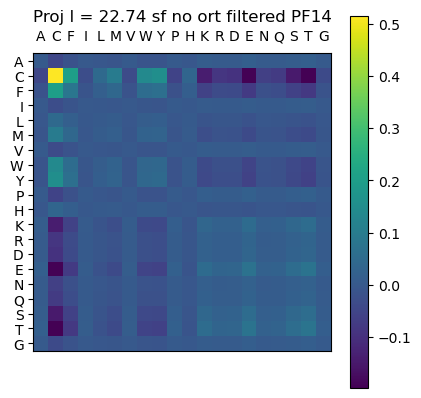

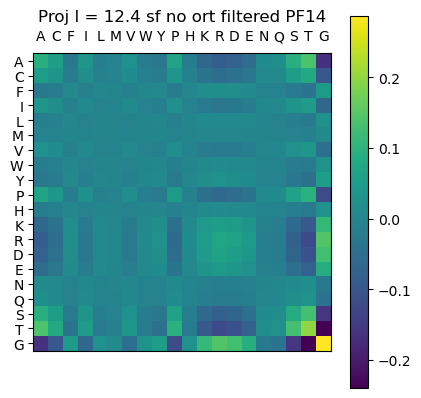

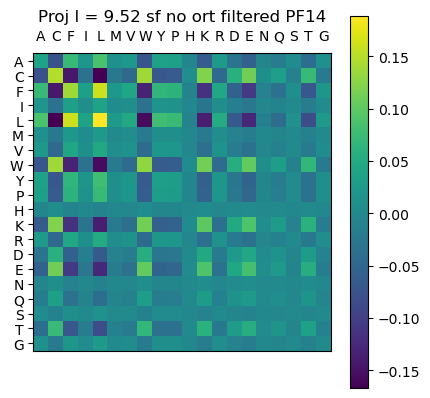

In [231]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf no ort filtered PF14")
;

Float32[-0.0024773441 -0.002477354 -0.0024773625 -0.0024773516 -0.0024773513 -0.002477331 -0.0024773476 -0.0024773737 -0.0024773618 -0.0024773781 -0.0024773513 -0.002477337 -0.0024773525 -0.0024773548 -0.0024773702 -0.0024773544 -0.002477352 -0.0024773586 -0.0024773474 -0.002477347 -0.0024773532]
Float32[-0.0024773488; -0.0024773614; -0.002477356; -0.0024773537; -0.0024773523; -0.002477346; -0.002477344; -0.0024773756; -0.002477358; -0.0024773483; -0.0024773502; -0.0024773537; -0.002477352; -0.0024773548; -0.002477372; -0.0024773548; -0.002477352; -0.0024773548; -0.0024773474; -0.002477347; -0.0024773532;;]
Explained variance : Float32[0.11, 0.21, 0.3, 0.39]


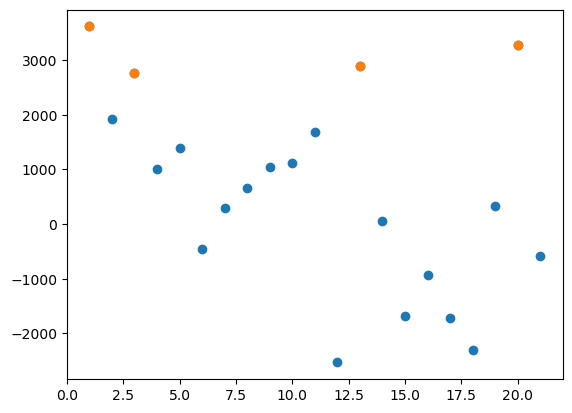

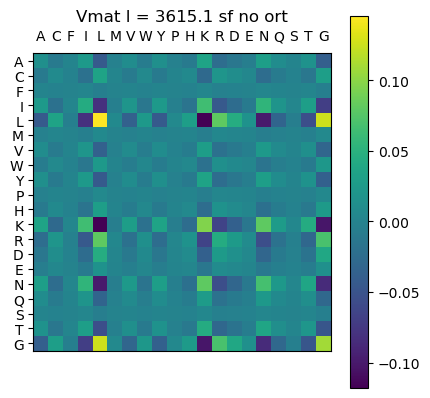

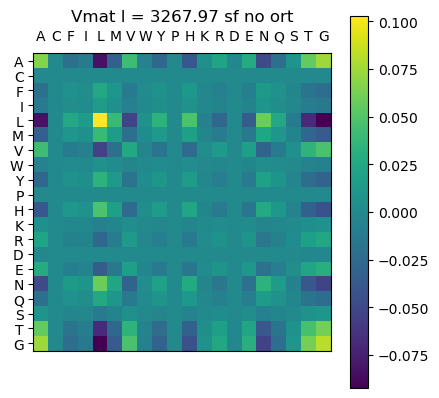

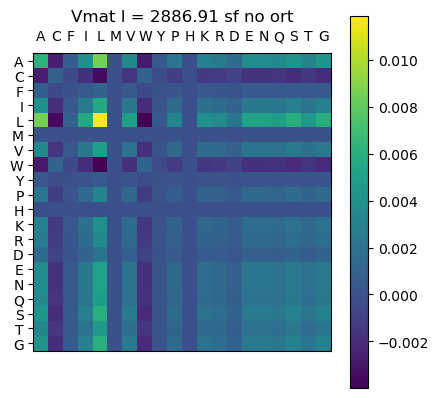

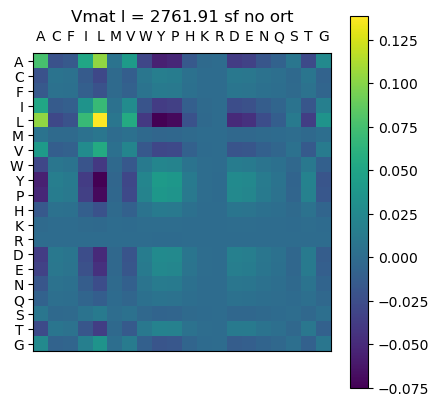

In [233]:
@load "../../DataAttentionDCA/data/PF13354/ortfalse_parsH21η0.5λ0.001T150.jld2"
m1 = m ; n_eig = 4; 
VV1 = showVmat_sf(m1, n_eig, tit = "sf no ort");

Explained Var : [0.26, 0.49, 0.63, 0.73]


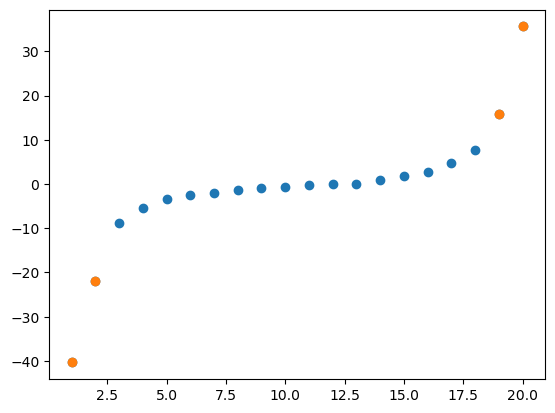

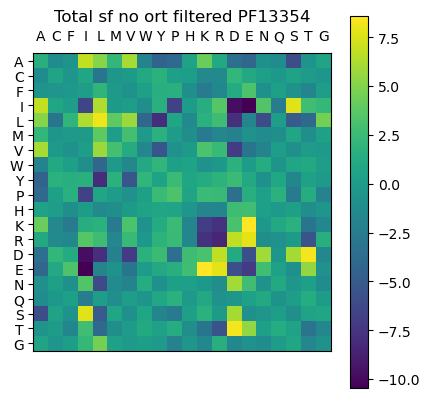

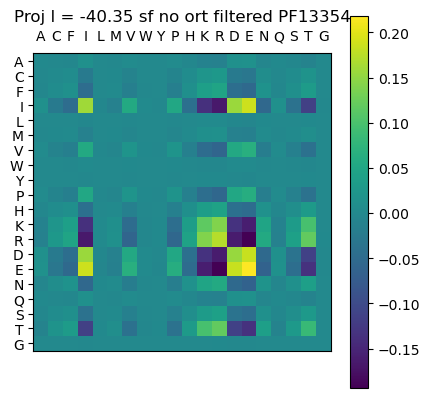

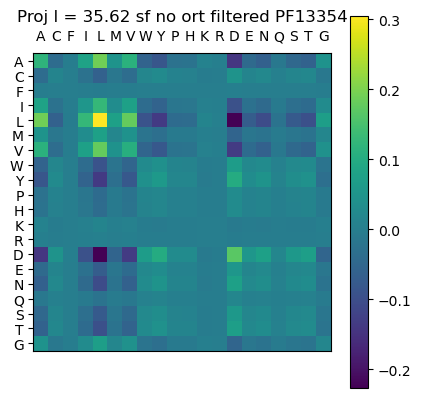

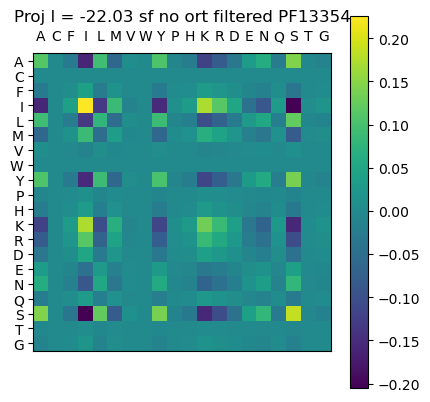

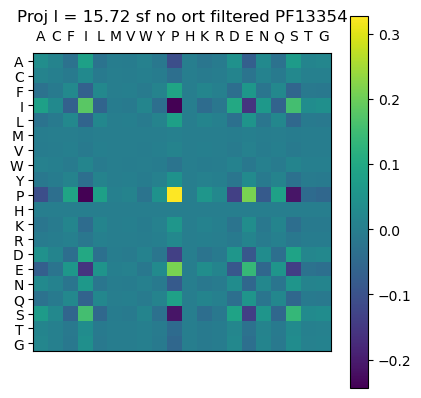

In [232]:
@load "../../DataAttentionDCA/data/PF13354/ortfalse_parsH21η0.5λ0.001T150.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF13354/PF13354_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf no ort filtered PF13354")
;

## Multi family no ort

(108,)
(18,)
(45,)
(0,)
(24,)
(22,)
(196,)
(2,)
(58,)
Explained Var : [0.25, 0.41, 0.5, 0.59]


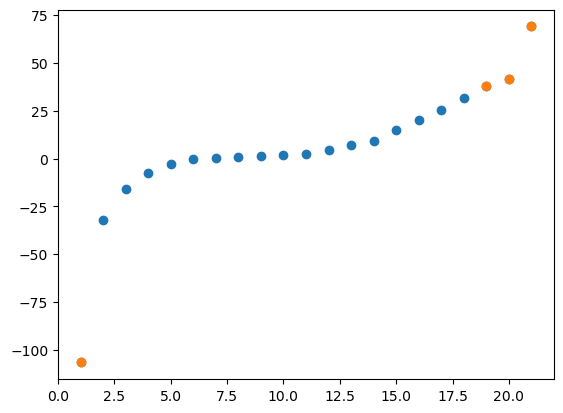

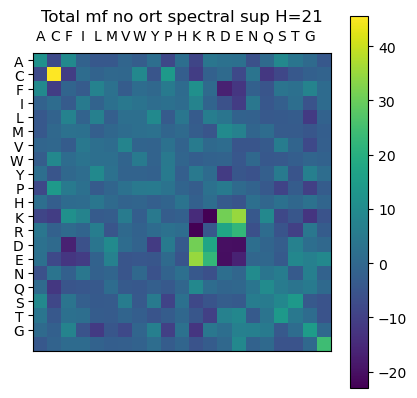

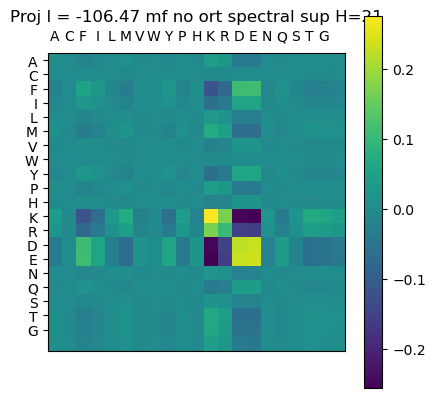

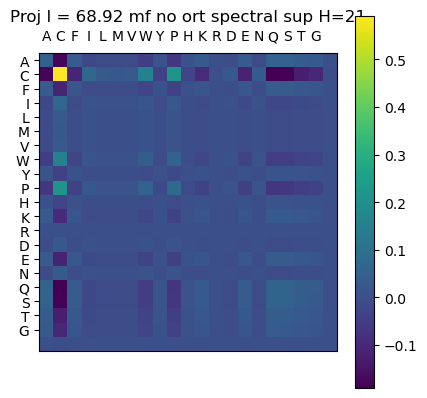

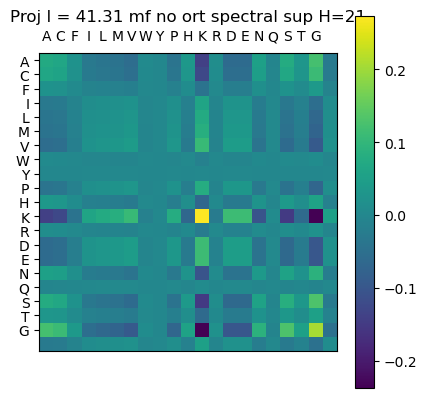

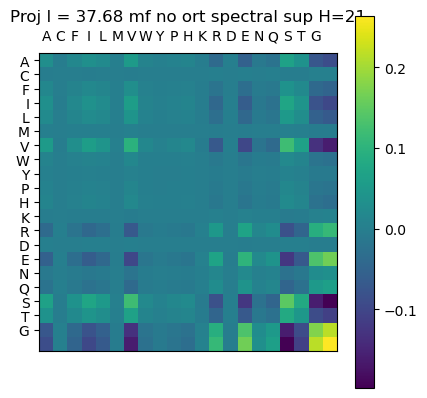

In [14]:
@load "../../multi_fam/ortfalse_H21η0.05λ0.001/mf_pars14_H21η0.05λ0.001T40.jld2"
fs = [14, 90, 105, 131, 200, 412, 1807, 2953, 7648]
structfiles = [joinpath("../", structs_dict[f]) for f in fs]
m1 = m ; n_eig = 4;


aa = get_filt_mat_mf(m1.Ks, m1.V, structfiles, ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "mf no ort spectral sup H=21")

;

Explained variance : [0.07, 0.13, 0.19, 0.25]


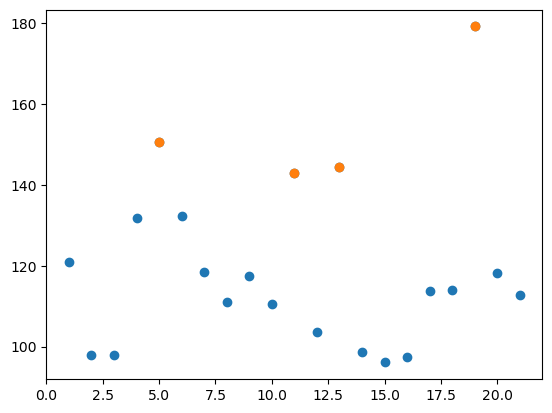

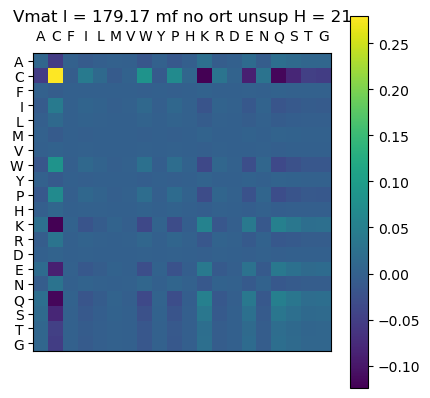

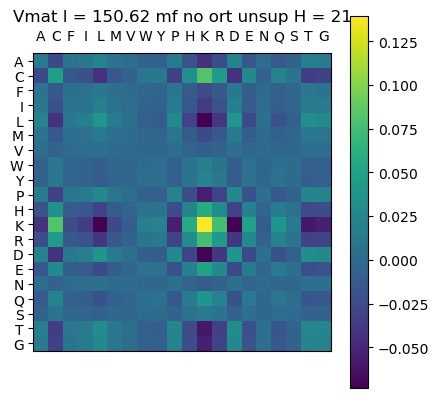

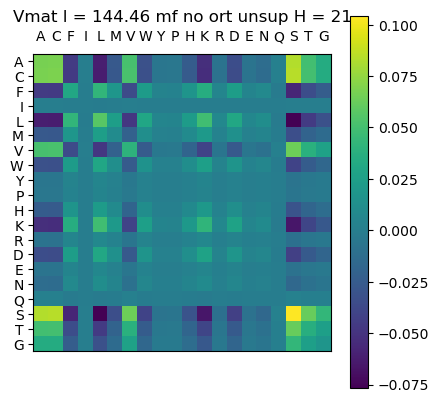

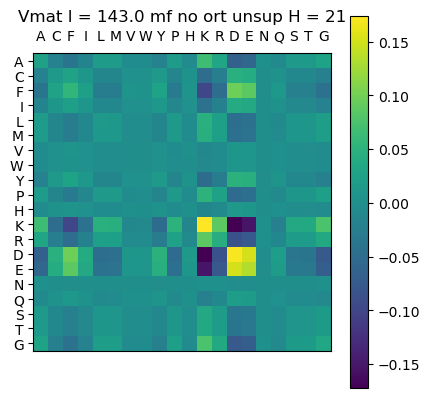

In [19]:
@load "../../multi_fam/ortfalse_H21η0.05λ0.001/mf_pars14_H21η0.05λ0.001T40.jld2"
fs = [14, 90, 105, 131, 200, 412, 1807, 2953, 7648]
m1 = m ; n_eig = 4;
showVmat_mf_uns(m1, n_eig, tit = "mf no ort unsup H = 21")
#la matrice con l'elettrostatico è la 11, la matrice con la cisteina è la 19
;

(109,)
(16,)
(44,)
(0,)
(23,)
(19,)
(195,)
(2,)
(62,)
Explained variance : [0.18, 0.33, 0.42, 0.5]


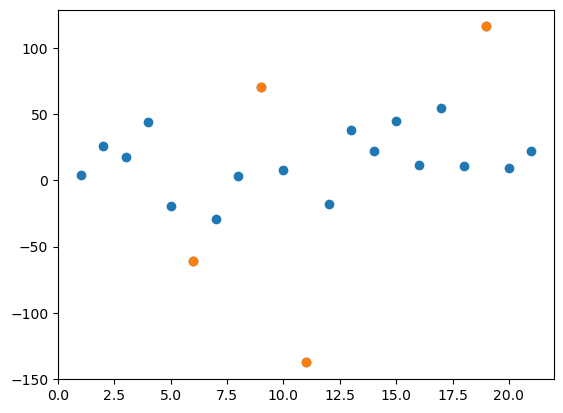

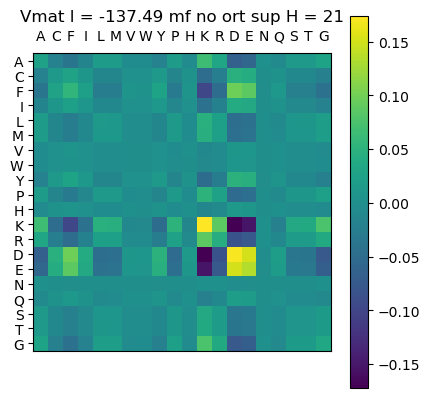

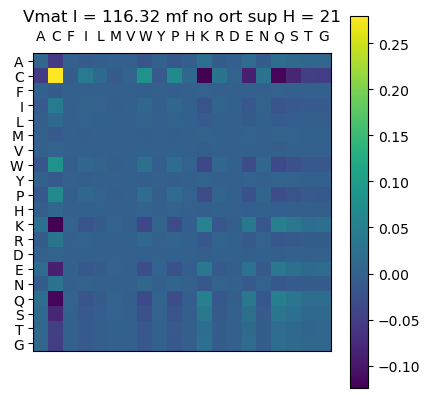

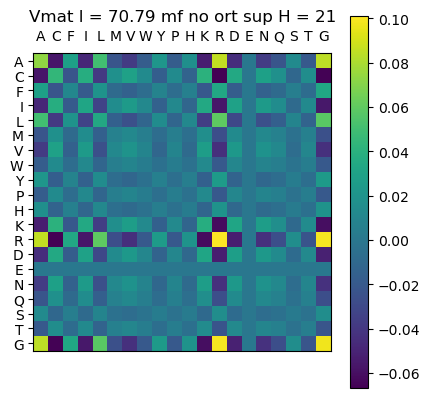

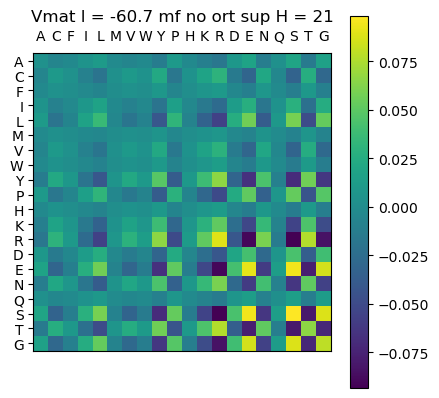

In [20]:
@load "../../multi_fam/ortfalse_H21η0.05λ0.001/mf_pars14_H21η0.05λ0.001T40.jld2"
fs = [14, 90, 105, 131, 200, 412, 1807, 2953, 7648]
structfiles = [joinpath("../", structs_dict[f]) for f in fs]
m1 = m ; n_eig = 4;
showVmat_mf(m1, n_eig, structfiles, tit = "mf no ort sup H = 21")
#la matrice con l'elettrostatico è la 11, la matrice con la cisteina è la 19
;

(106,)
(69,)
(169,)
(34,)
Explained variance : [0.14, 0.27, 0.37, 0.45]


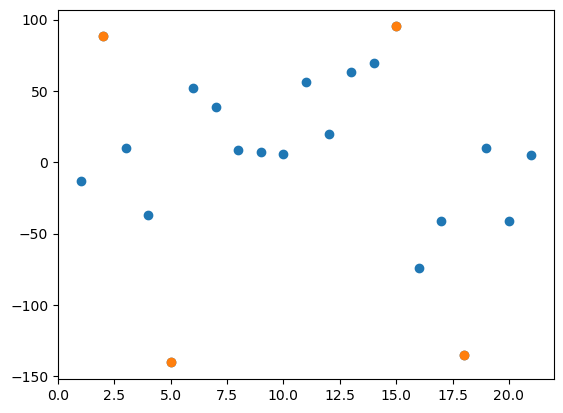

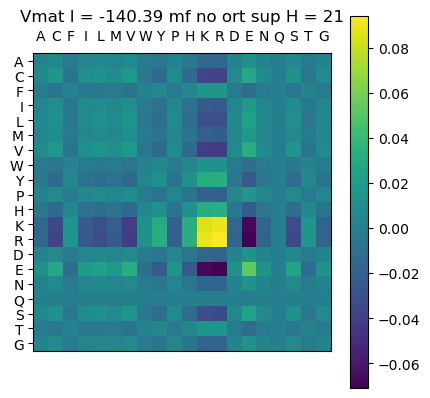

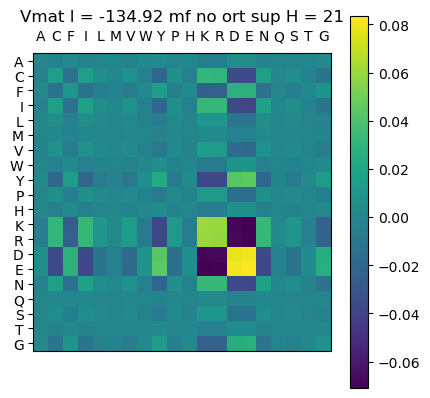

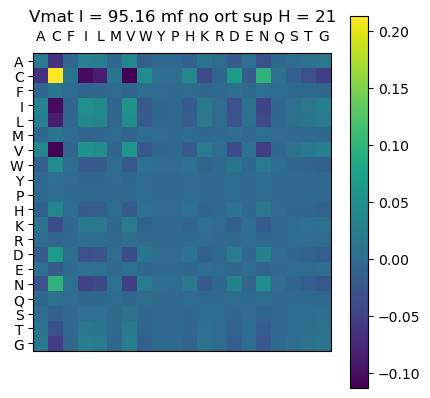

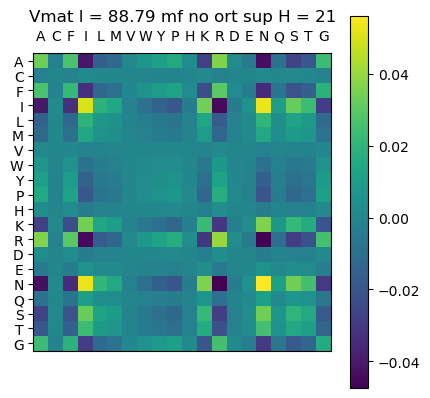

In [362]:
@load "../../multi_fam/ortfalse_H21η0.05λ0.001/mf_pars105_H21η0.05λ0.001T60.jld2"
m1 = m ; n_eig = 4;
fs = [14, 105, 1807, 7648]
structfiles = [joinpath("../", structs_dict[f]) for f in fs]
showVmat_mf(m1, n_eig, structfiles, tit = "mf no ort sup H = 21")
#showVmat_mf_uns(m1, n_eig, tit = "mf no ort unsup H = 21", perc = 1.)
;

Explained variance : [0.05, 0.09, 0.13, 0.16]


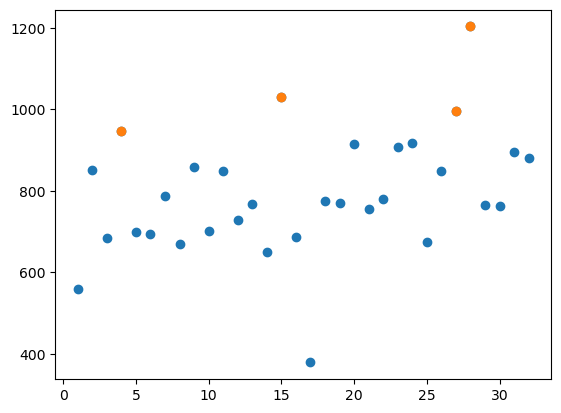

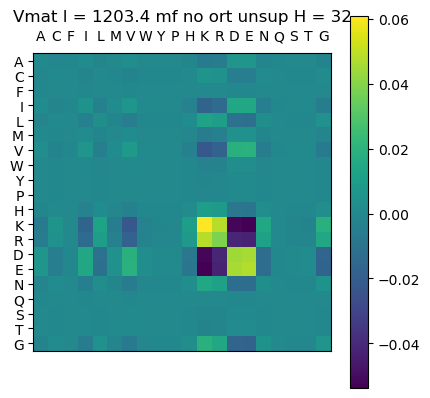

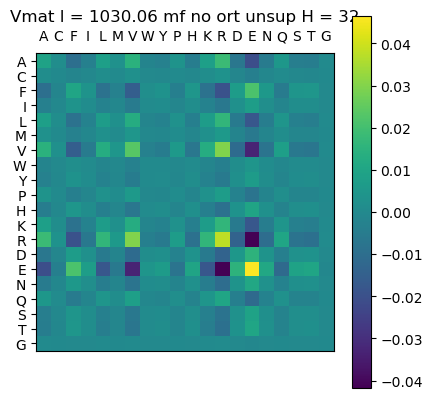

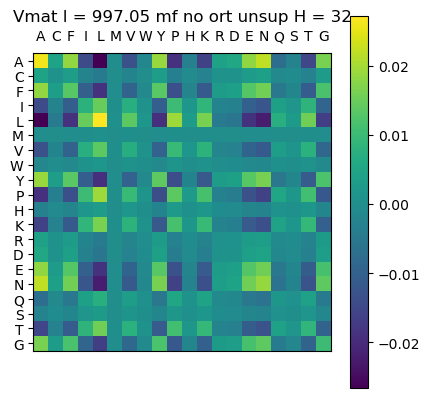

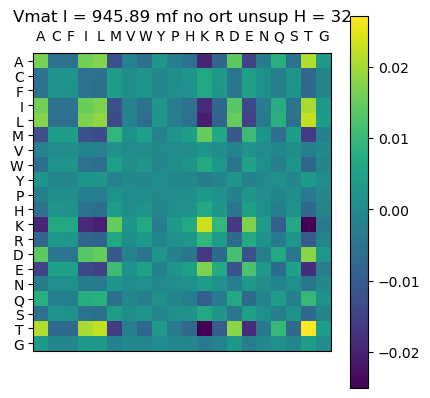

In [366]:
@load "../../multi_fam/H32η0.5λ0.001/mf_pars14_H32η0.5λ0.001T60.jld2"
m1 = m ; n_eig = 4;
showVmat_mf_uns(m1, n_eig, tit = "mf no ort unsup H = 32", perc = 0.8)
#la matrice con l'elettrostatico è la 11, la matrice con la cisteina è la 19
;

Explained variance : [0.1, 0.16, 0.22, 0.28, 0.33, 0.39]


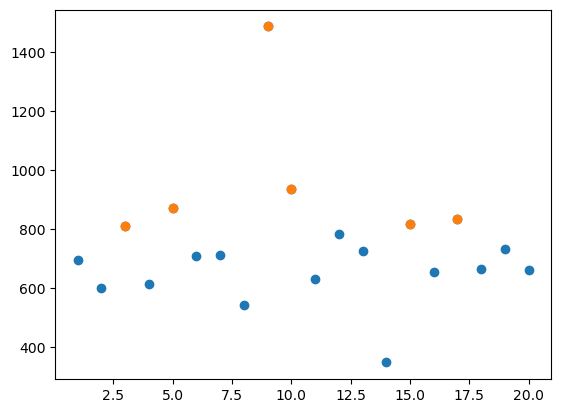

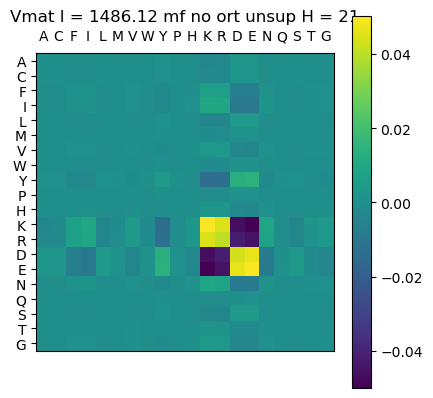

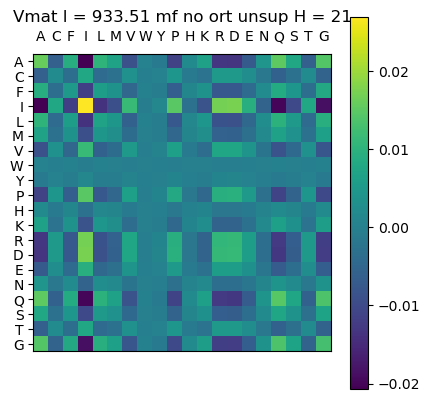

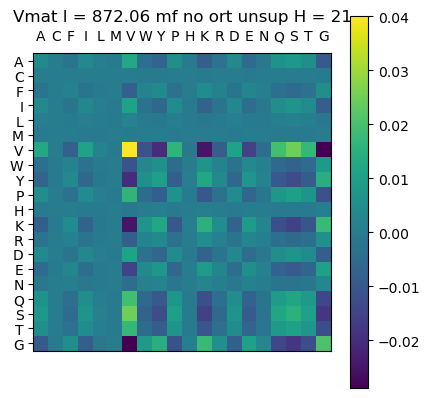

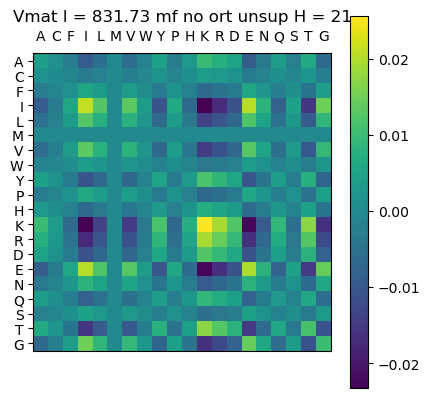

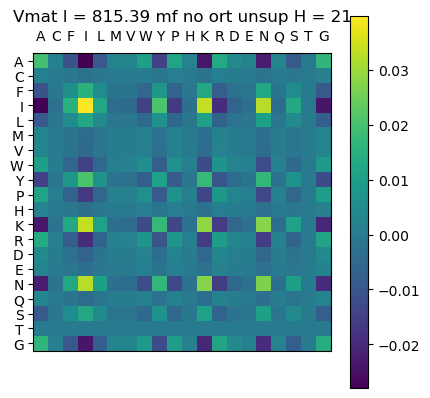

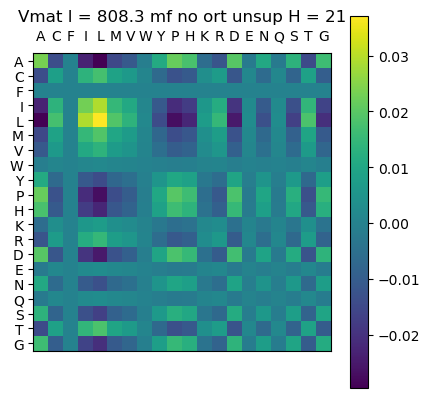

In [367]:
@load "../../multi_fam/H20η0.5λ0.001/parsH20.jld2"
m1 = m ; n_eig = 6;
showVmat_mf_uns(m1, n_eig, tit = "mf no ort unsup H = 21", perc = 0.5)
#la matrice con l'elettrostatico è la 11, la matrice con la cisteina è la 19
;

# Statistical MJ

In [ ]:
function get_filt_mat_mf3(K,Vn, filestructs; mindist::Int=6, ppv_cutoff=0.8, order_Martin = [1, 2, 5, 8, 10, 11, 18, 19, 20, 13, 7, 9, 15, 3, 4, 12, 14, 16, 17, 6, 21])
    V = Vn[order_Martin, :]
    Nf = length(K)
    NN = [size(K[f], 1) for f in 1:Nf]
    N = maximum([size(K[f], 1) for f in 1:Nf])
    H = size(K[1], 3)
    KK = zeros(N,N,q,q)
    counts = zeros(N, N, H)
    for f in 1:Nf
        gr = sel_good_res(K[f], V, filestructs[f], mindist = mindist, ppv_cutoff = ppv_cutoff) 
        println(size(gr))
        for n in 1:size(gr,1)
            for h in 1:H
                JJ[gr[n][1], gr[n][2], a, b] += K[f][gr[n][1], gr[n][2], h]
                counts[gr[n][1], gr[n][2], h] += 1
            end
        end
    end
    
    JJ[JJ.!=0] ./= counts[JJ.!=0]
    J0 = mean(mean(J, dims = 3), dims=4)  
    JJ_zs = J .- mean(J, dims = 3) .- mean(J, dims = 4) .+ J0 
    @tullio e[a,b] := JJ_zs[i,j,a,b]*(j!=i)
    e_tot = (e .+ e')./2 
    return e_tot
end
  

In [28]:
fs = [14, 35, 76, 90, 105, 131, 200, 412, 593, 595, 1774, 1807, 2953, 7648]
freq1 = []
freq2 = []
q = 21

for f in fs[1:1]
    Z, W = quickread(joinpath("../",seq_paths_dict[f]))
    println(size(W))
    f1, f2 = compute_weighted_frequencies(Z, q+1, 0.2)
    println(size(f1))
    println(size(f2))
end



Meff = 2950.925530761646
(8871,)
θ = 0.2 threshold = 10.0
M = 8871 N = 53 Meff = 4645.142374563081
(1113,)
[1.0000000000000022 1.0000000000000016 1.0000000000000027 1.0000000000000007 1.000000000000001 1.000000000000003 1.0000000000000024 1.0000000000000022 1.0000000000000016 1.0000000000000018 1.0000000000000024 1.0000000000000029 1.000000000000003 1.0000000000000027 1.000000000000003 1.000000000000003 1.0000000000000007 0.9999999999999992 1.0000000000000007 1.0000000000000007 1.0000000000000002 1.0000000000000033 1.0000000000000018 1.000000000000003 1.0000000000000029 1.0000000000000029 0.9999999999999998 1.000000000000003 1.0000000000000024 1.000000000000002 1.0000000000000033 1.000000000000001 0.9999999999999989 1.0000000000000016 1.0000000000000022 1.0000000000000018 1.0000000000000024 1.0000000000000029 1.0000000000000029 1.0000000000000004 1.0000000000000004 1.0000000000000029 1.0000000000000033 0.9999999999999996 1.000000000000004 1.0000000000000009 1.0000000000000022 1.0000000

In [96]:
function get_true_contacts(filestruct; min_separation=6, cutoff=8.0 )
    
    dist = compute_residue_pair_dist(filestruct)
    
    for (key,value) in dist
        if key[2]-key[1]<=min_separation || value > cutoff || value == 0 
            delete!(dist,key)
        end
    end
    
    return dist
end

function sum_cont!(dir_corr, count, f1, f2, true_cont; q = 21)
    L = Int(size(f1,1)/q)
    f1pc, f2pc = pseudocount(f1, f2)
    for a in 1:q
        for b in 1:q
            if haskey(true_cont, (i,j))
                count[i,j] += 1
                for i in 1:L
                    for b in 1:L
                        dir_corr[i, j] += f2pc[a+(i-1)*q, b+(j-1)*q] / (f1pc[a+(i-1)*q] * f1pc[b+(j-1)*q])
                    end
                end
            end
        end
    end
end


function stat_mj(z_paths, struct_paths)
    Zs =
    for i in 1:length(z_paths)
        Zs, W = quickread(z_paths[i])
    end
    
    f1, f2 = compute_weighted_frequencies(Z, q+1, 0.2)
        true_cont = get_true_contacts(struct_paths[i]);
        
    
    
end
    
    

sum_cont! (generic function with 1 method)

In [92]:
function pseudocount(f1, f2; alpha = 10^-4, q = 21)
    f1pc = (1 - alpha) * f1 .+ (alpha/q)
    f2pc = (1 - alpha) * f2 .+ (alpha/(q*q))
    return f1pc, f2pc
end
    

pseudocount (generic function with 1 method)

In [97]:
dir_corr = zeros(21, 21, 53, 53)
@time sum_cont!(dir_corr, count, f1, f2, true_cont)

  0.057634 seconds (13.58 k allocations: 19.822 MiB, 72.97% compilation time)


In [101]:
maximum(dir_corr2)

9999.999999999998

In [103]:
sum(abs2, dir_corr .- dir_corr2)

0.0

In [99]:
@load "../../multi_fam/ortfalse_H20η0.05λ0.001/12_fams_pars_H20.jld2"

1-element Vector{Symbol}:
 :m

get_true_contacts (generic function with 1 method)

In [62]:
true_cont = get_true_contacts(joinpath("../", structs_dict[14]));

In [61]:
if haskey(true_cont, (26, 10))
    println(1)
end

In [ ]:
"../../D